In [39]:
import numpy as np 
from sympy import Matrix
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.linalg import eigh, sqrtm
from scipy.optimize import curve_fit
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams.update({'font.size': 22})

The bath Hamiltonian is 

$$H_B = \frac12 \vec{p_k}^T \mathbb{I} \vec{p_k} + \frac{1}{2}P_-^2 + \frac12 \vec{p_l}^T \mathbb{I} \vec{p_l} + \frac{1}{2}P_+^2 + \frac12 \vec{p_n}^T \mathbb{I} \vec{p_n} + \frac{g}{2} \vec{q_k}^T \tilde{\mathbb{V}} \vec{q_k} + \frac{\Omega^2}{2}Q_-^2 + \frac{g}{2} \vec{q_l}^T \mathbb{V} \vec{q_l}+ \frac{\Omega^2}{2}Q_+^2 + \frac{g}{2} \vec{q_n}^T \tilde{\mathbb{V}} \vec{q_n}$$

The spatial part of the Hamiltonian can be represented in matrix form as 

$$ H_B = \begin{pmatrix} \frac{g}{2} \tilde{\mathbb{V}} &&&&\\& \frac{\Omega^2}{2}&&& \\ &&\frac{g}{2} \mathbb{V} &&\\ &&& \frac{\Omega^2}{2}& \\ &&&& \frac{g}{2} \tilde{\mathbb{V}}  \end{pmatrix}$$

In [2]:
# Function to create the V matrices 
def V_matrix(N,tilde='full',a=-1.0, b=2.0, c=-1.0, k1=-1, k2=0, k3=1):
    A = [a for i in range(N-1)]
    B = [b for i in range(N)]
    C = [c for i in range(N-1)]
    V = np.diag(A, k1) + np.diag(B, k2) + np.diag(C, k3)
    if tilde=='down':
        V[N-1,N-1] = 1
    elif tilde=='up':
        V[0,0] = 1
        
    return V

# Just to display
def view(M):
    display(Matrix(M))
    
def compose_matrix(Matrices):
    return True

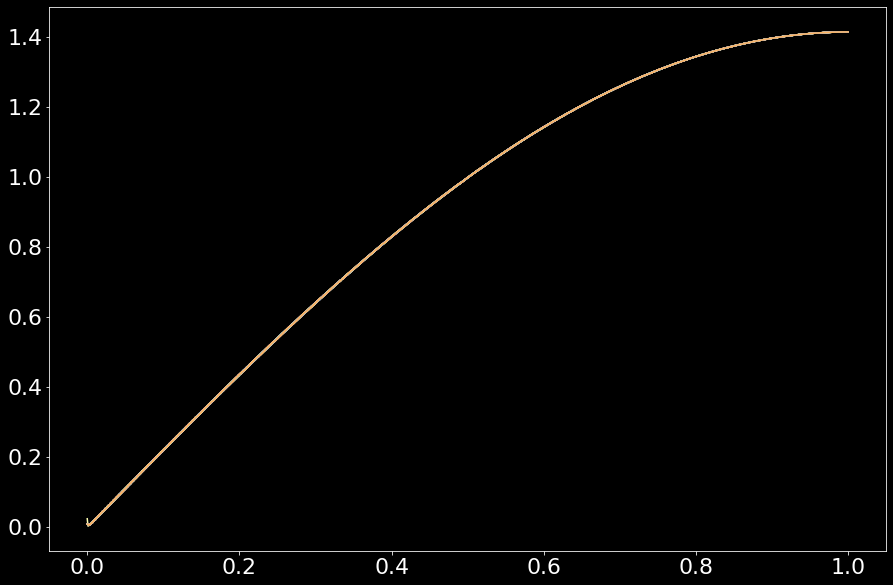

In [45]:
g = 1
m = 1
δm = 1e6
M = m+δm
μ = m/M
Ω = np.sqrt(2*g*μ)
c = -0.5*g*np.sqrt(μ)

N_sites = 1000


L = 500
N = int((N_sites - L -2)/2)

M_k = g*V_matrix(N,tilde='down')/2
M_l = g*V_matrix(L)/2
M_n = g*V_matrix(N,tilde='up')/2
#M_n[0,0] = g/2; M_n[N-1,N-1] = g

dim = 2*N + L + 2
H = np.zeros((dim,dim),dtype=np.float64)

H[0:N,0:N] = M_k
H[N,N] = Ω**2 / 2.
H[N,N+1] = H[N,N-1] = H[N+1,N] = H[N-1,N] = c
H[N+1:N+1+L,N+1:N+1+L] = M_l
H[N+L+1,N+L+1] = Ω**2 / 2.
H[N+L+1,N+L+2] = H[N+L+1,N+L] = H[N+L+2,N+L+1] = H[N+L,N+L+1] = c
H[N+L+2:2*N+L+3,N+L+2:2*N+L+3] = M_n
    
eigvals = eigh(H,eigvals_only=True)
x = np.linspace(0,1,len(eigvals))
E_ref = simps(np.sqrt(np.abs(eigvals)),x)
#dims_sum = eigvals.shape[0]
#E_ref = np.sum(np.sqrt(np.abs(eigvals)))
plt.plot(x,np.sqrt(np.abs(eigvals)))



size = 50
L_array = np.arange(0,size,2,dtype=np.int32)

E = np.zeros(len(L_array),dtype=np.float64)

for i in range(len(L_array)):
    # Creating matrices

    L = L_array[i]
    N = int((N_sites - L -2)/2) 
    
    M_k = g*V_matrix(N,tilde='down')/2
    M_l = g*V_matrix(L)/2
    M_n = g*V_matrix(N,tilde='up')/2
    #M_n[0,0] = g/2; M_n[N-1,N-1] = g
    
    dim = 2*N + L + 2
    H = np.zeros((dim,dim),dtype=np.float64)
    
    H[0:N,0:N] = M_k
    H[N,N] = Ω**2 / 2
    H[N,N+1] = H[N,N-1] = H[N+1,N] = H[N-1,N] = c
    H[N+1:N+1+L,N+1:N+1+L] = M_l
    H[N+L+1,N+L+1] = Ω**2 / 2
    H[N+L+1,N+L+2] = H[N+L+1,N+L] = H[N+L+2,N+L+1] = H[N+L,N+L+1] = c
    H[N+L+2:2*N+L+3,N+L+2:2*N+L+3] = M_n
    
    eigvals = eigh(H,eigvals_only=True)
    x = np.linspace(0,1,len(eigvals))
    E[i] = simps(np.sqrt(np.abs(eigvals)),x)
    #E[i] = np.sum(np.sqrt(np.abs(eigvals[0:dims_sum])))
    plt.plot(x,np.sqrt(np.abs(eigvals)))
    
    


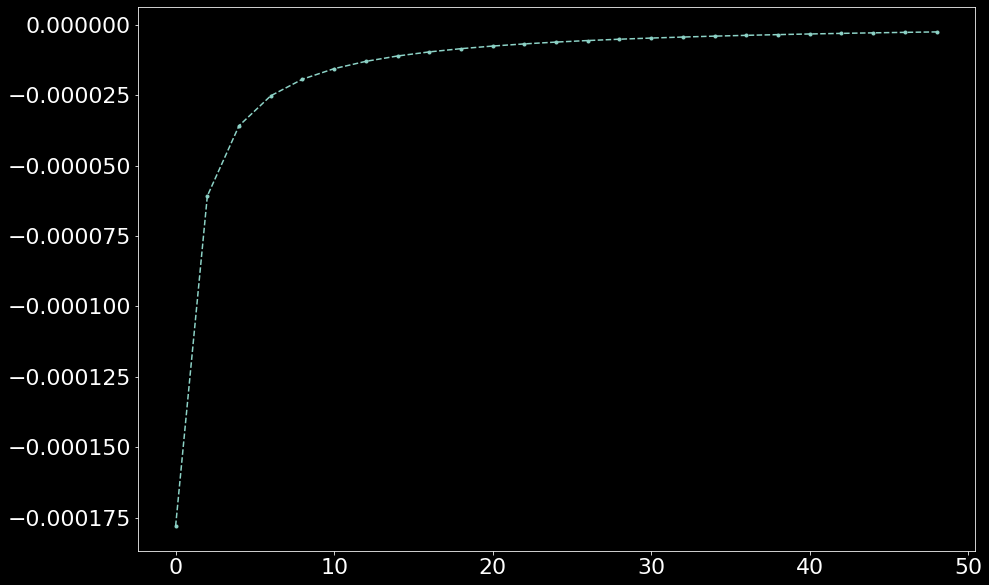

In [46]:
Δ = E-E_ref
plt.plot(L_array,Δ,'.--')

/home/alejandro/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[-1.78629236e-04  1.00000000e+00 -1.01542209e+00]
Equation: 
 -0.0*(x+1.0)^-1.015


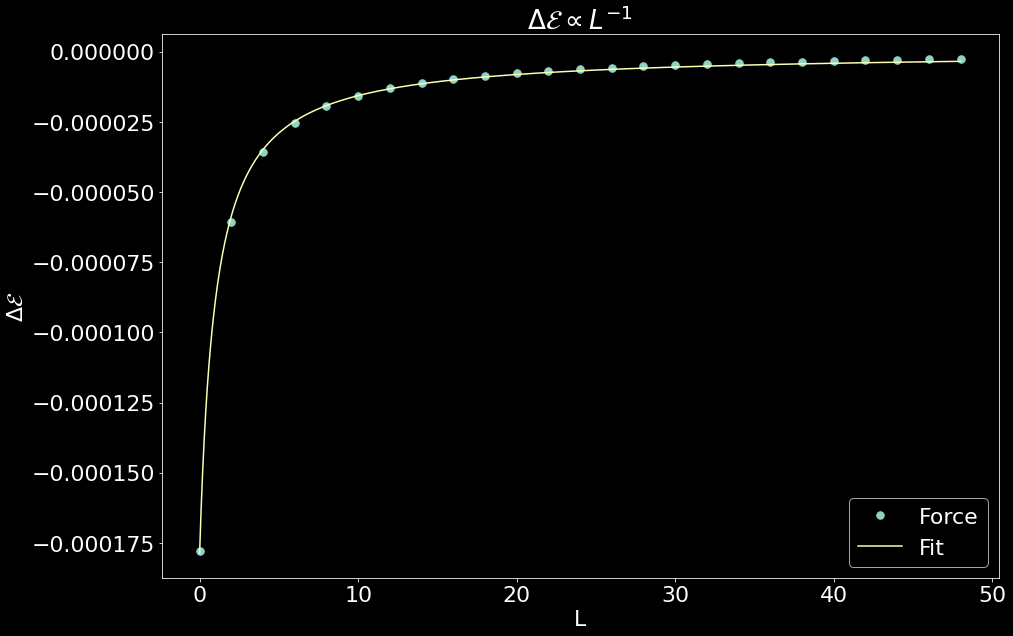

In [47]:
def Energy_model(x,a,b,c):
    return a*(x+1)**c 

fit_energy,_ = curve_fit(Energy_model,L_array,Δ)
print(fit_energy)
a,b,c = fit_energy[0],fit_energy[1],fit_energy[2]

L_dense = np.linspace(L_array[0],L_array[-1],1000)
Energy_dense = Energy_model(L_dense,a,b,c)

print("Equation: \n",str(a.round(3))+"*(x+"+str(b.round(3))+")^"+str(c.round(3)))

plt.plot(L_array,Δ,'.',ms=15)
plt.plot(L_dense,Energy_dense,'-')
plt.title('$\Delta \mathcal{E} \propto L^{-1}$')
plt.xlabel('L')
plt.ylabel('$\Delta \mathcal{E}$')
plt.legend(['Force','Fit'])
plt.savefig("Casenefit.png",dpi=400,transparent=True)